In [1]:
from guppy import hpy

import sys
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import Birch
from  sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
#from sklearn import manhattan_distances
from sklearn.metrics.pairwise import manhattan_distances
#from sklearn import birch
from sklearn.cluster import Birch

In [2]:
import warnings
import numpy as np
from scipy import sparse
from math import sqrt

#import sklearn.metrics.pairwise as spc

from sklearn.metrics.pairwise import euclidean_distances, haversine_distances
from sklearn.base import TransformerMixin, ClusterMixin, BaseEstimator
from sklearn.utils import check_array
from sklearn.utils.extmath import row_norms, safe_sparse_dot
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError, ConvergenceWarning
from sklearn.cluster.hierarchical import AgglomerativeClustering


def _iterate_sparse_X(X):
    """This little hack returns a densified row when iterating over a sparse
    matrix, instead of constructing a sparse matrix for every row that is
    expensive.
    """
    n_samples = X.shape[0]
    X_indices = X.indices
    X_data = X.data
    X_indptr = X.indptr

    for i in range(n_samples):
        row = np.zeros(X.shape[1])
        startptr, endptr = X_indptr[i], X_indptr[i + 1]
        nonzero_indices = X_indices[startptr:endptr]
        row[nonzero_indices] = X_data[startptr:endptr]
        yield row


def _split_node(node, threshold, branching_factor):
    """The node has to be split if there is no place for a new subcluster
    in the node.
    1. Two empty nodes and two empty subclusters are initialized.
    2. The pair of distant subclusters are found.
    3. The properties of the empty subclusters and nodes are updated
       according to the nearest distance between the subclusters to the
       pair of distant subclusters.
    4. The two nodes are set as children to the two subclusters.
    """
    new_subcluster1 = _CFSubcluster()
    new_subcluster2 = _CFSubcluster()
    new_node1 = _CFNode(
        threshold, branching_factor, is_leaf=node.is_leaf,
        n_features=node.n_features)
    new_node2 = _CFNode(
        threshold, branching_factor, is_leaf=node.is_leaf,
        n_features=node.n_features)
    new_subcluster1.child_ = new_node1
    new_subcluster2.child_ = new_node2

    if node.is_leaf:
        if node.prev_leaf_ is not None:
            node.prev_leaf_.next_leaf_ = new_node1
        new_node1.prev_leaf_ = node.prev_leaf_
        new_node1.next_leaf_ = new_node2
        new_node2.prev_leaf_ = new_node1
        new_node2.next_leaf_ = node.next_leaf_
        if node.next_leaf_ is not None:
            node.next_leaf_.prev_leaf_ = new_node2

    print("Dimension of node.centroids", node.centroids_.shape)
    print("Dimension of subcluster", len(node.subclusters_))
    print("Dimension of subcluster center", len(node.subclusters_[0].centroid_))
    #create matrinx for manhattan distance
    final_matrix = []
    for item in node.subclusters_:
        final_matrix.append(item.centroid_)
    final_matrix = np.asarray(final_matrix)
    print ("Diamension of final array is", final_matrix.shape)
    
    dist = manhattan_distances(node.centroids_, final_matrix)
    
    
    
    
    corr = np.corrcoef(node.centroids_)
    
#     pdist = spc.distance.pdist(corr)
    #dist = corr
#    linkage = spc.linkage(pdist, method='complete')
#    idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
    n_clusters = dist.shape[0]

    farthest_idx = np.unravel_index(dist.argmax(), (n_clusters, n_clusters))
    node1_dist, node2_dist = dist[(farthest_idx,)]

#     farthest_idx = np.unravel_index(
#         dist.argmax(), (n_clusters, n_clusters))
    
#     node1_dist = pdist[(idx,)]
#     node2_dist = node1_dist
    
    node1_closer = node1_dist < node2_dist
    for idx, subcluster in enumerate(node.subclusters_):
        if node1_closer[idx]:
            new_node1.append_subcluster(subcluster)
            new_subcluster1.update(subcluster)
        else:
            new_node2.append_subcluster(subcluster)
            new_subcluster2.update(subcluster)
    return new_subcluster1, new_subcluster2


class _CFNode:
    """Each node in a CFTree is called a CFNode.

    The CFNode can have a maximum of branching_factor
    number of CFSubclusters.

    Parameters
    ----------
    threshold : float
        Threshold needed for a new subcluster to enter a CFSubcluster.

    branching_factor : int
        Maximum number of CF subclusters in each node.

    is_leaf : bool
        We need to know if the CFNode is a leaf or not, in order to
        retrieve the final subclusters.

    n_features : int
        The number of features.

    Attributes
    ----------
    subclusters_ : array-like
        list of subclusters for a particular CFNode.

    prev_leaf_ : _CFNode
        prev_leaf. Useful only if is_leaf is True.

    next_leaf_ : _CFNode
        next_leaf. Useful only if is_leaf is True.
        the final subclusters.

    init_centroids_ : ndarray, shape (branching_factor + 1, n_features)
        manipulate ``init_centroids_`` throughout rather than centroids_ since
        the centroids are just a view of the ``init_centroids_`` .

    init_sq_norm_ : ndarray, shape (branching_factor + 1,)
        manipulate init_sq_norm_ throughout. similar to ``init_centroids_``.

    centroids_ : ndarray
        view of ``init_centroids_``.

    squared_norm_ : ndarray
        view of ``init_sq_norm_``.

    """
    def __init__(self, threshold, branching_factor, is_leaf, n_features):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.is_leaf = is_leaf
        self.n_features = n_features

        # The list of subclusters, centroids and squared norms
        # to manipulate throughout.
        self.subclusters_ = []
        self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
        self.init_sq_norm_ = np.zeros((branching_factor + 1))
        self.squared_norm_ = []
        self.prev_leaf_ = None
        self.next_leaf_ = None

    def append_subcluster(self, subcluster):
        n_samples = len(self.subclusters_)
        self.subclusters_.append(subcluster)
        self.init_centroids_[n_samples] = subcluster.centroid_
        self.init_sq_norm_[n_samples] = subcluster.sq_norm_

        # Keep centroids and squared norm as views. In this way
        # if we change init_centroids and init_sq_norm_, it is
        # sufficient,
        self.centroids_ = self.init_centroids_[:n_samples + 1, :]
        self.squared_norm_ = self.init_sq_norm_[:n_samples + 1]

    def update_split_subclusters(self, subcluster,
                                 new_subcluster1, new_subcluster2):
        """Remove a subcluster from a node and update it with the
        split subclusters.
        """
        ind = self.subclusters_.index(subcluster)
        self.subclusters_[ind] = new_subcluster1
        self.init_centroids_[ind] = new_subcluster1.centroid_
        self.init_sq_norm_[ind] = new_subcluster1.sq_norm_
        self.append_subcluster(new_subcluster2)

    def insert_cf_subcluster(self, subcluster):
        """Insert a new subcluster into the node."""
        if not self.subclusters_:
            self.append_subcluster(subcluster)
            return False

        threshold = self.threshold
        branching_factor = self.branching_factor
        # We need to find the closest subcluster among all the
        # subclusters so that we can insert our new subcluster.
        dist_matrix = np.dot(self.centroids_, subcluster.centroid_)
        dist_matrix *= -2.
        dist_matrix += self.squared_norm_
        closest_index = np.argmin(dist_matrix)
        closest_subcluster = self.subclusters_[closest_index]

        # If the subcluster has a child, we need a recursive strategy.
        if closest_subcluster.child_ is not None:
            split_child = closest_subcluster.child_.insert_cf_subcluster(
                subcluster)

            if not split_child:
                # If it is determined that the child need not be split, we
                # can just update the closest_subcluster
                closest_subcluster.update(subcluster)
                self.init_centroids_[closest_index] = \
                    self.subclusters_[closest_index].centroid_
                self.init_sq_norm_[closest_index] = \
                    self.subclusters_[closest_index].sq_norm_
                return False

            # things not too good. we need to redistribute the subclusters in
            # our child node, and add a new subcluster in the parent
            # subcluster to accommodate the new child.
            else:
                new_subcluster1, new_subcluster2 = _split_node(
                    closest_subcluster.child_, threshold, branching_factor)
                self.update_split_subclusters(
                    closest_subcluster, new_subcluster1, new_subcluster2)

                if len(self.subclusters_) > self.branching_factor:
                    return True
                return False

        # good to go!
        else:
            merged = closest_subcluster.merge_subcluster(
                subcluster, self.threshold)
            if merged:
                self.init_centroids_[closest_index] = \
                    closest_subcluster.centroid_
                self.init_sq_norm_[closest_index] = \
                    closest_subcluster.sq_norm_
                return False

            # not close to any other subclusters, and we still
            # have space, so add.
            elif len(self.subclusters_) < self.branching_factor:
                self.append_subcluster(subcluster)
                return False

            # We do not have enough space nor is it closer to an
            # other subcluster. We need to split.
            else:
                self.append_subcluster(subcluster)
                return True


class _CFSubcluster:
    """Each subcluster in a CFNode is called a CFSubcluster.

    A CFSubcluster can have a CFNode has its child.

    Parameters
    ----------
    linear_sum : ndarray, shape (n_features,), optional
        Sample. This is kept optional to allow initialization of empty
        subclusters.

    Attributes
    ----------
    n_samples_ : int
        Number of samples that belong to each subcluster.

    linear_sum_ : ndarray
        Linear sum of all the samples in a subcluster. Prevents holding
        all sample data in memory.

    squared_sum_ : float
        Sum of the squared l2 norms of all samples belonging to a subcluster.

    centroid_ : ndarray
        Centroid of the subcluster. Prevent recomputing of centroids when
        ``CFNode.centroids_`` is called.

    child_ : _CFNode
        Child Node of the subcluster. Once a given _CFNode is set as the child
        of the _CFNode, it is set to ``self.child_``.

    sq_norm_ : ndarray
        Squared norm of the subcluster. Used to prevent recomputing when
        pairwise minimum distances are computed.
    """
    def __init__(self, linear_sum=None):
        if linear_sum is None:
            self.n_samples_ = 0
            self.squared_sum_ = 0.0
            self.centroid_ = self.linear_sum_ = 0
        else:
            self.n_samples_ = 1
            self.centroid_ = self.linear_sum_ = linear_sum
            self.squared_sum_ = self.sq_norm_ = np.dot(
                self.linear_sum_, self.linear_sum_)
        self.child_ = None

    def update(self, subcluster):
        self.n_samples_ += subcluster.n_samples_
        self.linear_sum_ += subcluster.linear_sum_
        self.squared_sum_ += subcluster.squared_sum_
        self.centroid_ = self.linear_sum_ / self.n_samples_
        self.sq_norm_ = np.dot(self.centroid_, self.centroid_)

    def merge_subcluster(self, nominee_cluster, threshold):
        """Check if a cluster is worthy enough to be merged. If
        yes then merge.
        """
        new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
        new_ls = self.linear_sum_ + nominee_cluster.linear_sum_
        new_n = self.n_samples_ + nominee_cluster.n_samples_
        new_centroid = (1 / new_n) * new_ls
        new_norm = np.dot(new_centroid, new_centroid)
        dot_product = (-2 * new_n) * new_norm
        sq_radius = (new_ss + dot_product) / new_n + new_norm
        if sq_radius <= threshold ** 2:
            (self.n_samples_, self.linear_sum_, self.squared_sum_,
             self.centroid_, self.sq_norm_) = \
                new_n, new_ls, new_ss, new_centroid, new_norm
            return True
        return False

    @property
    def radius(self):
        """Return radius of the subcluster"""
        dot_product = -2 * np.dot(self.linear_sum_, self.centroid_)
        return sqrt(
            ((self.squared_sum_ + dot_product) / self.n_samples_) +
            self.sq_norm_)


class Birch(BaseEstimator, TransformerMixin, ClusterMixin):
    """Implements the Birch clustering algorithm.

    It is a memory-efficient, online-learning algorithm provided as an
    alternative to :class:`MiniBatchKMeans`. It constructs a tree
    data structure with the cluster centroids being read off the leaf.
    These can be either the final cluster centroids or can be provided as input
    to another clustering algorithm such as :class:`AgglomerativeClustering`.

    Read more in the :ref:`User Guide <birch>`.

    Parameters
    ----------
    threshold : float, default 0.5
        The radius of the subcluster obtained by merging a new sample and the
        closest subcluster should be lesser than the threshold. Otherwise a new
        subcluster is started. Setting this value to be very low promotes
        splitting and vice-versa.

    branching_factor : int, default 50
        Maximum number of CF subclusters in each node. If a new samples enters
        such that the number of subclusters exceed the branching_factor then
        that node is split into two nodes with the subclusters redistributed
        in each. The parent subcluster of that node is removed and two new
        subclusters are added as parents of the 2 split nodes.

    n_clusters : int, instance of sklearn.cluster model, default 3
        Number of clusters after the final clustering step, which treats the
        subclusters from the leaves as new samples.

        - `None` : the final clustering step is not performed and the
          subclusters are returned as they are.

        - `sklearn.cluster` Estimator : If a model is provided, the model is
          fit treating the subclusters as new samples and the initial data is
          mapped to the label of the closest subcluster.

        - `int` : the model fit is :class:`AgglomerativeClustering` with
          `n_clusters` set to be equal to the int.

    compute_labels : bool, default True
        Whether or not to compute labels for each fit.

    copy : bool, default True
        Whether or not to make a copy of the given data. If set to False,
        the initial data will be overwritten.

    Attributes
    ----------
    root_ : _CFNode
        Root of the CFTree.

    dummy_leaf_ : _CFNode
        Start pointer to all the leaves.

    subcluster_centers_ : ndarray,
        Centroids of all subclusters read directly from the leaves.

    subcluster_labels_ : ndarray,
        Labels assigned to the centroids of the subclusters after
        they are clustered globally.

    labels_ : ndarray, shape (n_samples,)
        Array of labels assigned to the input data.
        if partial_fit is used instead of fit, they are assigned to the
        last batch of data.

    Examples
    --------
    >>> from sklearn.cluster import Birch
    >>> X = [[0, 1], [0.3, 1], [-0.3, 1], [0, -1], [0.3, -1], [-0.3, -1]]
    >>> brc = Birch(branching_factor=50, n_clusters=None, threshold=0.5,
    ... compute_labels=True)
    >>> brc.fit(X) # doctest: +NORMALIZE_WHITESPACE
    Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,
       threshold=0.5)
    >>> brc.predict(X)
    array([0, 0, 0, 1, 1, 1])

    References
    ----------
    * Tian Zhang, Raghu Ramakrishnan, Maron Livny
      BIRCH: An efficient data clustering method for large databases.
      https://www.cs.sfu.ca/CourseCentral/459/han/papers/zhang96.pdf

    * Roberto Perdisci
      JBirch - Java implementation of BIRCH clustering algorithm
      https://code.google.com/archive/p/jbirch

    Notes
    -----
    The tree data structure consists of nodes with each node consisting of
    a number of subclusters. The maximum number of subclusters in a node
    is determined by the branching factor. Each subcluster maintains a
    linear sum, squared sum and the number of samples in that subcluster.
    In addition, each subcluster can also have a node as its child, if the
    subcluster is not a member of a leaf node.

    For a new point entering the root, it is merged with the subcluster closest
    to it and the linear sum, squared sum and the number of samples of that
    subcluster are updated. This is done recursively till the properties of
    the leaf node are updated.
    """

    def __init__(self, threshold=0.5, branching_factor=50, n_clusters=3,
                 compute_labels=True, copy=True):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_clusters = n_clusters
        self.compute_labels = compute_labels
        self.copy = copy

    def fit(self, X, y=None):
        """
        Build a CF Tree for the input data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Input data.

        y : Ignored

        """
        self.fit_, self.partial_fit_ = True, False
        return self._fit(X)

    def _fit(self, X):
        X = check_array(X, accept_sparse='csr', copy=self.copy)
        threshold = self.threshold
        branching_factor = self.branching_factor

        if branching_factor <= 1:
            raise ValueError("Branching_factor should be greater than one.")
        n_samples, n_features = X.shape

        # If partial_fit is called for the first time or fit is called, we
        # start a new tree.
        partial_fit = getattr(self, 'partial_fit_')
        has_root = getattr(self, 'root_', None)
        if getattr(self, 'fit_') or (partial_fit and not has_root):
            # The first root is the leaf. Manipulate this object throughout.
            self.root_ = _CFNode(threshold, branching_factor, is_leaf=True,
                                 n_features=n_features)

            # To enable getting back subclusters.
            self.dummy_leaf_ = _CFNode(threshold, branching_factor,
                                       is_leaf=True, n_features=n_features)
            self.dummy_leaf_.next_leaf_ = self.root_
            self.root_.prev_leaf_ = self.dummy_leaf_

        # Cannot vectorize. Enough to convince to use cython.
        if not sparse.issparse(X):
            iter_func = iter
        else:
            iter_func = _iterate_sparse_X

        for sample in iter_func(X):
            subcluster = _CFSubcluster(linear_sum=sample)
            split = self.root_.insert_cf_subcluster(subcluster)

            if split:
                new_subcluster1, new_subcluster2 = _split_node(
                    self.root_, threshold, branching_factor)
                del self.root_
                self.root_ = _CFNode(threshold, branching_factor,
                                     is_leaf=False,
                                     n_features=n_features)
                self.root_.append_subcluster(new_subcluster1)
                self.root_.append_subcluster(new_subcluster2)

        centroids = np.concatenate([
            leaf.centroids_ for leaf in self._get_leaves()])
        self.subcluster_centers_ = centroids

        self._global_clustering(X)
        return self

    def _get_leaves(self):
        """
        Retrieve the leaves of the CF Node.

        Returns
        -------
        leaves : array-like
            List of the leaf nodes.
        """
        leaf_ptr = self.dummy_leaf_.next_leaf_
        leaves = []
        while leaf_ptr is not None:
            leaves.append(leaf_ptr)
            leaf_ptr = leaf_ptr.next_leaf_
        return leaves

    def partial_fit(self, X=None, y=None):
        """
        Online learning. Prevents rebuilding of CFTree from scratch.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features), None
            Input data. If X is not provided, only the global clustering
            step is done.

        y : Ignored

        """
        self.partial_fit_, self.fit_ = True, False
        if X is None:
            # Perform just the final global clustering step.
            self._global_clustering()
            return self
        else:
            self._check_fit(X)
            return self._fit(X)

    def _check_fit(self, X):
        is_fitted = hasattr(self, 'subcluster_centers_')

        # Called by partial_fit, before fitting.
        has_partial_fit = hasattr(self, 'partial_fit_')

        # Should raise an error if one does not fit before predicting.
        if not (is_fitted or has_partial_fit):
            raise NotFittedError("Fit training data before predicting")

        if is_fitted and X.shape[1] != self.subcluster_centers_.shape[1]:
            raise ValueError(
                "Training data and predicted data do "
                "not have same number of features.")

    def predict(self, X):
        """
        Predict data using the ``centroids_`` of subclusters.

        Avoid computation of the row norms of X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Input data.

        Returns
        -------
        labels : ndarray, shape(n_samples)
            Labelled data.
        """
        X = check_array(X, accept_sparse='csr')
        self._check_fit(X)
        reduced_distance = safe_sparse_dot(X, self.subcluster_centers_.T)
        reduced_distance *= -2
        reduced_distance += self._subcluster_norms
        return self.subcluster_labels_[np.argmin(reduced_distance, axis=1)]

    def transform(self, X):
        """
        Transform X into subcluster centroids dimension.

        Each dimension represents the distance from the sample point to each
        cluster centroid.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Input data.

        Returns
        -------
        X_trans : {array-like, sparse matrix}, shape (n_samples, n_clusters)
            Transformed data.
        """
        check_is_fitted(self, 'subcluster_centers_')
        return euclidean_distances(X, self.subcluster_centers_)

    def _global_clustering(self, X=None):
        """
        Global clustering for the subclusters obtained after fitting
        """
        clusterer = self.n_clusters
        centroids = self.subcluster_centers_
        compute_labels = (X is not None) and self.compute_labels

        # Preprocessing for the global clustering.
        not_enough_centroids = False
        if isinstance(clusterer, int):
            clusterer = AgglomerativeClustering(
                n_clusters=self.n_clusters)
            # There is no need to perform the global clustering step.
            if len(centroids) < self.n_clusters:
                not_enough_centroids = True
        elif (clusterer is not None and not
              hasattr(clusterer, 'fit_predict')):
            raise ValueError("n_clusters should be an instance of "
                             "ClusterMixin or an int")

        # To use in predict to avoid recalculation.
        self._subcluster_norms = row_norms(
            self.subcluster_centers_, squared=True)

        if clusterer is None or not_enough_centroids:
            self.subcluster_labels_ = np.arange(len(centroids))
            if not_enough_centroids:
                warnings.warn(
                    "Number of subclusters found (%d) by Birch is less "
                    "than (%d). Decrease the threshold."
                    % (len(centroids), self.n_clusters), ConvergenceWarning)
        else:
            # The global clustering step that clusters the subclusters of
            # the leaves. It assumes the centroids of the subclusters as
            # samples and finds the final centroids.
            self.subcluster_labels_ = clusterer.fit_predict(
                self.subcluster_centers_)

        if compute_labels:
            self.labels_ = self.predict(X)


In [3]:
#read the dataset
import pandas as pd
df = pd.read_excel("./dataset/data_set_ALL_AML_train.xlsx")
start = datetime.now()

In [4]:
birch = Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,threshold=2000)
birch.fit_transform(df)



Dimension of node.centroids (51, 38)
Dimension of subcluster 51
Dimension of subcluster center 38
Diamension of final array is (51, 38)
Dimension of node.centroids (51, 38)
Dimension of subcluster 51
Dimension of subcluster center 38
Diamension of final array is (51, 38)
Dimension of node.centroids (51, 38)
Dimension of subcluster 51
Dimension of subcluster center 38
Diamension of final array is (51, 38)
Dimension of node.centroids (51, 38)
Dimension of subcluster 51
Dimension of subcluster center 38
Diamension of final array is (51, 38)
Dimension of node.centroids (51, 38)
Dimension of subcluster 51
Dimension of subcluster center 38
Diamension of final array is (51, 38)
Dimension of node.centroids (51, 38)
Dimension of subcluster 51
Dimension of subcluster center 38
Diamension of final array is (51, 38)
Dimension of node.centroids (51, 38)
Dimension of subcluster 51
Dimension of subcluster center 38
Diamension of final array is (51, 38)
Dimension of node.centroids (51, 38)
Dimension o

array([[112166.14302008,  88002.78687633, 118627.37222918, ...,
         86379.32270515,  68580.24286192,  69379.69001804],
       [112300.1101914 ,  88183.61524115, 118818.01108839, ...,
         86521.78631998,  68732.31007321,  69484.93482763],
       [111557.75113814,  87384.84630072, 117988.80191357, ...,
         85762.28896199,  67909.26119463,  68737.21262897],
       ...,
       [111375.69719198,  87237.3280368 , 117825.45100699, ...,
         85531.57274364,  67760.58509192,  68497.55188326],
       [108430.17133621,  84463.16268054, 114938.3075132 , ...,
         82557.92699069,  64864.83686097,  65671.42181345],
       [111654.76078072,  87520.32529076, 118114.80485951, ...,
         85797.82266468,  68041.62042456,  68774.4285327 ]])

In [5]:
#print(birch.heap())
#h=hpy()
#print(h.heap())

print(sys.getsizeof(birch))

56


In [6]:
time = datetime.now()-start
print("The time taken is ",(time.seconds*1000+time.microseconds/1000.0),"milliseconds" )

print(f"Cluster Size with threshold {birch.threshold} is ", len(birch.subcluster_centers_))

The time taken is  3575.2039999999997 milliseconds
Cluster Size with threshold 2000 is  924


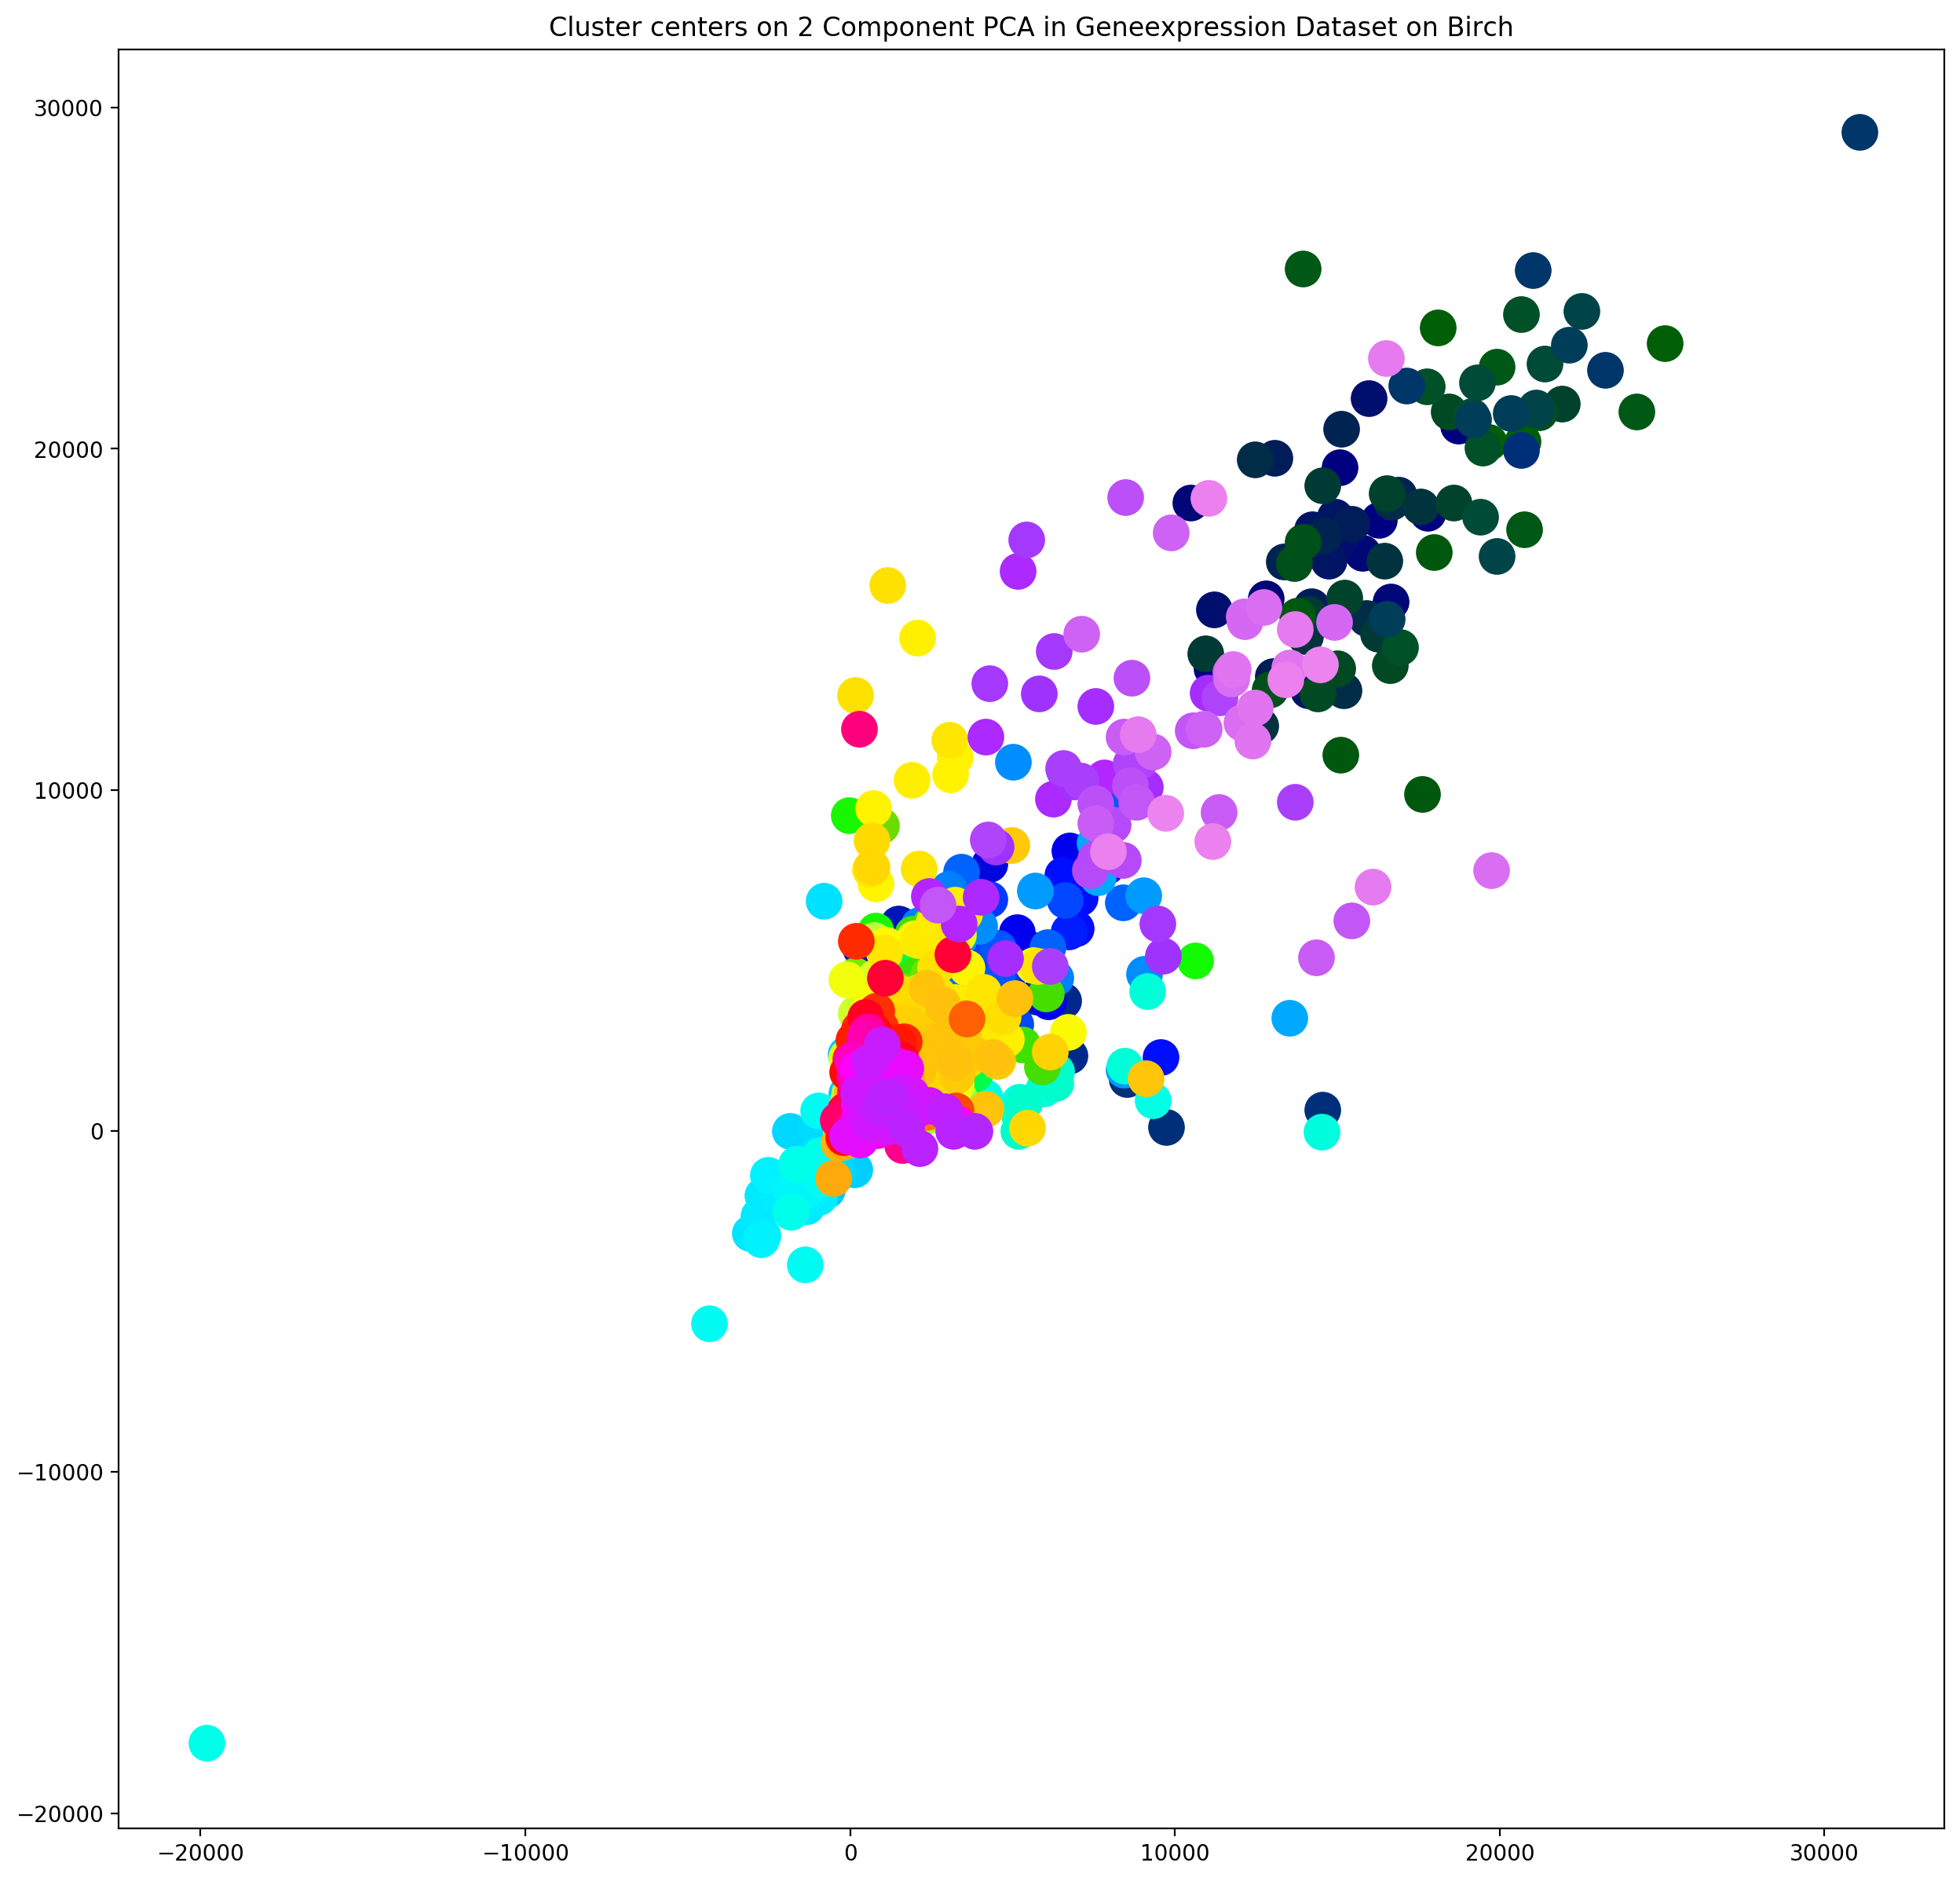

In [7]:
cluster_centers = birch.subcluster_centers_
labels = birch.labels_
fig = plt.figure(figsize=(15, 15), dpi=200)
ax = fig.add_subplot(111)
ax.set_title("Cluster centers on 2 Component PCA in Geneexpression Dataset on Birch")
for x,y,lab in zip(cluster_centers[:, 0],cluster_centers[:, 1],labels):
        ax.scatter(x,y,label=lab, s= 250)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

In [8]:
#import sklearn
#print(sklearn.__version__)